# Explaining the values 

In [2]:
import sys
import os
sys.path.append('../workspace/src/')

In [3]:
from torch_geometric.data import Batch
from torch_geometric.utils import to_dense_batch, to_scipy_sparse_matrix, scatter

In [4]:
from pair_graphs import InferenceDataset, collate_batch, PairDataset
from multimodal_attention_network_exp import NodeImpor, NodeRank

import pandas as pd
import umap
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import numpy as np
from rdkit import Chem, DataStructs
from scipy import stats
from scipy.spatial.distance import pdist,squareform
from train_drp import MultimodalAttentionNet, Conf
import torch
from multimodal_attention_network_exp import GAT
from torch.utils.data import DataLoader


/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [5]:
import numpy as np
from scipy.sparse import csc_matrix
from create_graphs_ppi import PPIGraphsL1000, PPIGraphsDRP
from tqdm import tqdm
%matplotlib inline

In [13]:
device = 'cpu'
gat = GAT(dim_in=5).to(device)
project_dir = Path('/workspace')
processed_dir = project_dir / 'data/processed/'
ppi = PPIGraphsDRP(project_dir)

In [7]:
class DatasetTest(torch.utils.data.Dataset):
    def __init__(self, labels_path: str = 'DRP',
                 problem: str ='regression', 
                 self_att: str = '', root: str = '/workspace'):
        self.problem = problem
        self.self_att = self_att
        self.root = root
        # self.root = Path(__file__).resolve().parents[1].absolute()
        # print(self.root)
        if 'DRP' in str(labels_path):
            # self.molecular_graphs = MolecularGraphs(self.root )
            self.ppi_graphs = PPIGraphsDRP(self.root, self_att=self_att )
        
        """for ppi_graph in self.ppi_graphs:
                cell_index.append(i)
                cellosaurus_accession.append(ppi_graph.cell_name)
                i += 1
        self.cell_indices = pd.Series(data=cell_index, index=cellosaurus_accession)
        """ 
        l= [i for i in range(len(self.ppi_graphs))]
        self.cell_indices = pd.Series(data=l, index=l)

    def __len__(self):
        return len(self.ppi_graphs)
    
    def __getitem__(self, idx):
        ppi_graph_idx = self.cell_indices[idx]	
        return self.ppi_graphs[ppi_graph_idx.tolist()]
    
    def pin_memory(self):
        return True

def collate_test(batch):
    batchB = Batch.from_data_list([data for data in batch])
    return batchB

In [8]:
ppi = DatasetTest()
dataloader = DataLoader(ppi, batch_size=10, shuffle=False, collate_fn=collate_test)

$\mathbf{x}^{(i+1)} = (1 - \alpha) \cdot \mathbf{A} \mathbf{x}^{(i)} + \alpha \mathbf{x}^{(0)}$

## Draw the attention of protein nodes
The experiment named 'epoch=212-step=1957470.ckpt'

In [9]:
att_df = pd.read_csv(processed_dir / 
        'NCI60DRP_random_self_att/attentionDRP.csv', index_col=0)
cells = att_df['cell'].unique()
att_df
e1 = att_df.loc[att_df['cell'] == 'CVCL_0292']['protein_1'].values
e2 = att_df.loc[att_df['cell'] == 'CVCL_0292']['protein_2'].values
edge_index = np.vstack((e1, e2))
att_ppi = torch.tensor(att_df.loc[att_df['cell'] == 
                        'CVCL_0292']['attention'].values).to(device)
att_ppi = att_ppi.double()
edge_index = torch.tensor(edge_index)
edge_index = edge_index.to(device)
nul_tensor = torch.zeros(len(att_df.loc[att_df['cell'] == 
                        'CVCL_0292']['protein_1'].unique()), dtype=torch.int64)
nul_tensor = nul_tensor.to(device)
batch_att_scipy = torch.sparse_coo_tensor(edge_index,
                                         att_ppi).double()
batch_att_scipy.shape
print('sum scatter along dim 0', scatter(att_ppi, edge_index[0], 
                                         dim=0, reduce='sum').squeeze())
print('sum attentions by node 2', att_ppi[edge_index[0] == 2].sum())

sum scatter along dim 0 tensor([17.3943,  1.1438,  7.7983,  ...,  6.7341, 16.7797,  3.7958],
       dtype=torch.float64)
sum attentions by node 2 tensor(7.7983, dtype=torch.float64)


In [10]:
# Create Page Rank Node Imporatance from attention matrix
def make_node_importance(att_df, device, cell):
    e1 = att_df.loc[att_df['cell'] == cell]['protein_1'].values
    e2 = att_df.loc[att_df['cell'] == cell]['protein_2'].values
    edge_index = np.vstack((e1, e2))
    att_ppi = torch.tensor(att_df.loc[att_df['cell'] == cell]['attention'].values).to(device)
    att_ppi = att_ppi.double()
    edge_index = torch.tensor(edge_index)
    edge_index = edge_index.to(device)
    nul_tensor = torch.zeros(len(att_df.loc[att_df['cell'] == cell]['protein_1'].unique()), dtype=torch.int64)
    nul_tensor = nul_tensor.to(device)
    batch_att_scipy = torch.sparse_coo_tensor(edge_index,
                                         att_ppi).double()
    att_ppi = att_ppi.unsqueeze(-1) # shape (B, |E|) - > (B, |E|, 1)
    # Use torch.bincount() to count the occurrences of each unique number
    torch.use_deterministic_algorithms(False)
    counts = torch.bincount(nul_tensor).to(device)
    # Calculate inverted counts
    inverted_counts =  1 / counts
    # Use torch.gather() to invert the counts for each node in the batch
    x0 = torch.gather(inverted_counts, 0, nul_tensor).unsqueeze(-1).double()
    # Create a diagonal matrix from the inverted counts
    diag = 1 / scatter(att_ppi, edge_index[0], dim=0, reduce='sum').squeeze()
    diag_inv = torch.diag(diag).to(device).double()

    a = torch.sparse.mm(batch_att_scipy, diag_inv)
    a = a.to_sparse()
    use_tqdm = True
    #progress = tqdm(range(100), unit_scale=True, 
    #                    leave=False, disable=not use_tqdm)
    d = 0.85
    ep = x0
    epsilon = 1e-6
    for i in range(1000):
        ep_old = ep
        # dense matrix to be added, sparse matrix to be multiplied, 
        # dense matrix to be multiplied, multiplier for added matrix, 
        # multiplier for product
        ep = torch.sparse.addmm(x0, a, ep, beta=1-d, alpha=d) 
        diff = torch.linalg.norm(ep - ep_old, ord=float("+inf"), axis=0)
        if (diff < epsilon).all():
            break
        mask = diff > epsilon

    print(f"Converged after {i} iterations up to {epsilon}.")
    return ep

In [35]:
def ni_to_df(att_df, cells, device):
    ni = []
    att_df = att_df.sort_values(by=['cell'])
    for cell in cells:
        ep = make_node_importance(att_df, device, cell)
        ni.append(ep)
    ni = torch.vstack(ni).detach().cpu().numpy()
    print('shape of node importances stacked', ni.shape)
    att_importance_nodes = att_df[['protein_1', 'p1_name', 'cell']].drop_duplicates().sort_values([ 'cell','protein_1'], ascending=[True, True])
    att_importance_nodes['node_importance'] = ni
    # att_importance_nodes.to_csv(processed_dir / 'NCI60DRPApr_random/att_importance_nodes.csv')
importance_nodes = pd.read_csv(processed_dir / 
    'NCI60DRPApr_random/att_importance_nodes.csv', index_col=0)
importance_nodes.head()

,protein_1,p1_name,cell,node_importance
394,0,ABCA13,CVCL_0004,0.000974
21,1,ACADL,CVCL_0004,0.000089
393,2,AFAP1,CVCL_0004,0.000400
291,3,AGO4,CVCL_0004,0.000988
254,4,AGT,CVCL_0004,0.000131


In [15]:
import seaborn as sns
import networkx as nx
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as pyo

In [16]:
att_df['cell'].unique()

array(['CVCL_0292', 'CVCL_1331', 'CVCL_1779', 'CVCL_1304', 'CVCL_1690',
       'CVCL_1092', 'CVCL_0021', 'CVCL_0062', 'CVCL_1195', 'CVCL_1051',
       'CVCL_0004'], dtype=object)

In [17]:
att_df.groupby('cell').count()

,attention,protein_1,protein_2,p1_name,p2_name
cell,,,,,
CVCL_0004,567,567,567,567,567
CVCL_0021,244,244,244,244,244
CVCL_0062,1120,1120,1120,1120,1120
CVCL_0292,102213,102213,102213,102213,102213
CVCL_1051,651,651,651,651,651
CVCL_1092,291,291,291,291,291
CVCL_1195,785,785,785,785,785
CVCL_1304,29218,29218,29218,29218,29218
CVCL_1331,33595,33595,33595,33595,33595


<AxesSubplot: xlabel='node_importance', ylabel='Count'>

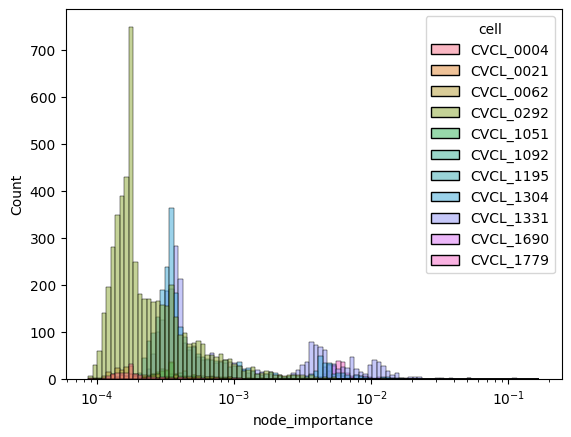

In [25]:
sns.histplot(importance_nodes, x='node_importance', hue='cell', bins=100, 
             log_scale=True)

<AxesSubplot: ylabel='Frequency'>

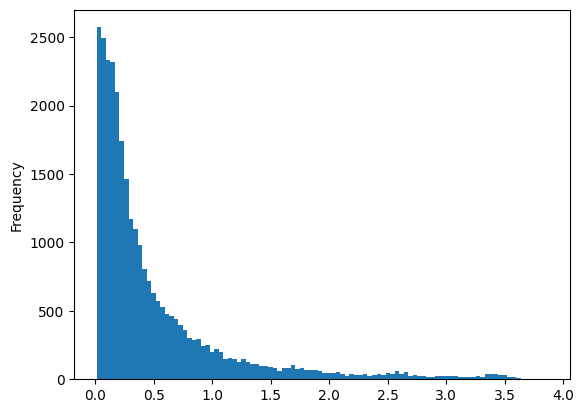

In [19]:
cvcl_1304 = att_df[att_df['cell'].str.contains('CVCL_1304')]
cvcl_1304['attention'].plot.hist(bins=100)

In [20]:
cvcl_1304_05 = cvcl_1304[cvcl_1304['attention'] > 0.5]
cvcl_1304_05

,attention,protein_1,protein_2,cell,p1_name,p2_name
1,0.858900,1199,478,CVCL_1304,M6PR,COMT
2,0.891869,1199,193,CVCL_1304,M6PR,ATP4A
9,1.347847,2308,689,CVCL_1304,USP28,ESPL1
14,2.694633,2308,2315,CVCL_1304,USP28,USP51
16,1.099197,2308,2286,CVCL_1304,USP28,UCK1
...,...,...,...,...,...,...
29213,0.696590,2467,2467,CVCL_1304,ZSCAN21,ZSCAN21
29214,0.583820,2468,2468,CVCL_1304,ZSCAN32,ZSCAN32
29215,1.303613,2469,2469,CVCL_1304,ZSCAN4,ZSCAN4
29216,1.658095,2470,2470,CVCL_1304,ZSWIM6,ZSWIM6


In [21]:
cvcl_1304_ = cvcl_1304[(cvcl_1304['p2_name'].isin(['PTEN', 'AXIN1'])) | (cvcl_1304['p1_name'].isin(['PTEN', 'AXIN1']))]
#cvcl_1304_ = cvcl_1304[cvcl_1304['p2_name'].isin(['PTEN', 'AXIN1'])]

cvcl_1304_

,attention,protein_1,protein_2,cell,p1_name,p2_name
27,0.181786,622,204,CVCL_1304,DVL2,AXIN1
107,0.064422,1634,1675,CVCL_1304,PPP5C,PTEN
198,0.185125,2372,204,CVCL_1304,YTHDC2,AXIN1
287,0.059241,907,1675,CVCL_1304,HEATR6,PTEN
757,0.059841,638,1675,CVCL_1304,EEF1A2,PTEN
...,...,...,...,...,...,...
26317,0.044701,785,1675,CVCL_1304,FRK,PTEN
26624,0.064104,20,1675,CVCL_1304,ACACA,PTEN
26730,0.038159,1981,1675,CVCL_1304,SMTN,PTEN
26950,0.186822,204,204,CVCL_1304,AXIN1,AXIN1


In [22]:
from bioservices import KEGG

def retrieve_kegg_biological_processes(gene_names):
    kegg = KEGG()

    # Return biological processes as dictionary with gene names as keys
    biological_processes = {}

    for gene_name in gene_names:
        try:
            # Search for the gene name in KEGG
            result = kegg.get_pathway_by_gene(gene=gene_name, organism="hsa")
            biological_processes[gene_name] = result
        except:
            biological_processes[gene_name] = []

    return biological_processes

# Example usage
gene_names = cvcl_1304_05['p2_name'].unique().tolist()
processes = retrieve_kegg_biological_processes(gene_names)

Creating directory /home/vscode/.cache/bioservices 
Welcome to Bioservices
It looks like you do not have a configuration file.
We are creating one with default values in /home/vscode/.config/bioservices/bioservices.cfg .
Done


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not o

## BREAST CANCER (CVCL_1092; BT-549)

<AxesSubplot: ylabel='Frequency'>

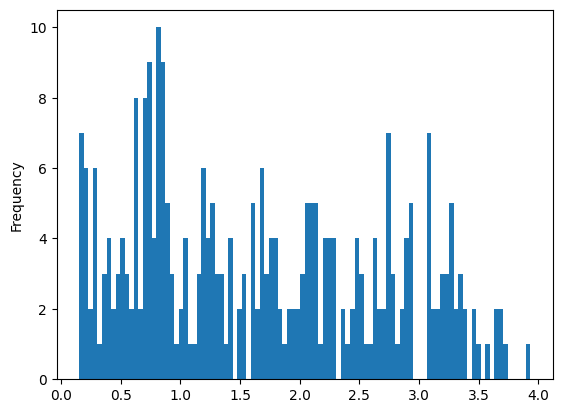

In [26]:
# Take smaller subset of genes related only to Non-small cell lung cancer
cvcl_1092 = att_df[att_df['cell'].str.contains('CVCL_1092')]
cvcl_1092['attention'].plot.hist(bins=100)

In [28]:
# Data - cell line
cvcl_1304 = att_df[att_df['cell'] == 'CVCL_1304']
#df = cvcl_1304[(cvcl_1304['p2_name'].isin(['PTEN', 'AXIN1'])) | (cvcl_1304['p1_name'].isin(['PTEN', 'AXIN1']))]

# Retrieve biological processes from KEGG
from bioservices import KEGG

def retrieve_kegg_biological_processes(gene_names):
    kegg = KEGG()

    # Return biological processes as dictionary with gene names as keys
    biological_processes = {}
    
    for gene_name in gene_names:
        try:
            # Search for the gene name in KEGG
            result = kegg.get_pathway_by_gene(gene=gene_name, organism="hsa")
            biological_processes[gene_name] = result
        except:
            biological_processes[gene_name] = []

    return biological_processes

# Example usage
gene_names_1304 = cvcl_1304['p2_name'].unique().tolist()
processes_1304 = retrieve_kegg_biological_processes(gene_names_1304)

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not o

In [29]:
# Write a function to prepaer df file from processes data
def prepare_df(processes):
    df = pd.DataFrame.from_dict(processes)
    df = df.melt(var_name='gene_name', value_name='biological_processes'
                 ).drop_duplicates().dropna().reset_index(drop=True)

    df = df[df['biological_processes'].str.contains('pathway|signal')
            ].reset_index(drop=True)
    
    df = df.drop_duplicates(subset=['gene_name'])
    return df

df = prepare_df(processes_1304)
df.head()

,gene_name,biological_processes
0,COMT,Metabolic pathways
1,ATP4A,Metabolic pathways
2,LRP2,Hedgehog signaling pathway
3,LGR4,Wnt signaling pathway
4,PFAS,Metabolic pathways


In [30]:
# Convert dictionary to dataframe
df = pd.DataFrame.from_dict(processes_1304)
df = df.melt(var_name='gene_name', value_name='biological_processes')
df = df.drop_duplicates(subset=['gene_name', 'biological_processes']
                        ).reset_index(drop=True)

df = df.dropna().reset_index(drop=True)
# Retain rows with 'path' or 'signal' in the biological processes
df = df[df['biological_processes'].str.contains('path|signal')
        ].reset_index(drop=True)

df.head()

,gene_name,biological_processes
0,COMT,Metabolic pathways
1,ATP4A,Metabolic pathways
2,LRP2,Hedgehog signaling pathway
3,LGR4,Wnt signaling pathway
4,PFAS,Metabolic pathways


In [33]:
# Remove rows with only one entry in biological processes
df = df.groupby('biological_processes').filter(lambda x: len(x) > 5
                                               ).reset_index(drop=True)
df.groupby('biological_processes')['gene_name'].count().sort_values(ascending=False)
df = df.drop_duplicates(subset='gene_name')
df = df.sort_values(by='biological_processes').reset_index(drop=True)

nod_cvcl_1304 = importance_nodes[importance_nodes['cell'] == 'CVCL_1304']
nod_cvcl_1304 = nod_cvcl_1304[['p1_name', 'node_importance']]
nod_cvcl_1304 = nod_cvcl_1304.rename(columns={'p1_name': 'node'})

#df = df.merge(nod_cvcl_1304, left_on='gene_name', right_on='node', how='left').dropna().reset_index(drop=True)
#df = df.sort_values(by='biological_processes', ascending=False) 

# Write function to prepare cell line data
def prepare_cell_line_data(df, cell_line, node_importance):
    data = cell_line[(cell_line['p2_name'].isin(df['gene_name'])) & 
                    (cell_line['p1_name'].isin(df['gene_name']))
                    ].drop_duplicates().reset_index(drop=True)
    
    data = data.merge(df, left_on='p2_name', right_on='gene_name', 
                      how='left').dropna().reset_index(drop=True)
    
    data = data.merge(node_importance, left_on='p2_name', right_on='node',
                      how='left')

    # Drop biological proceses with less than 2 genes
    data = data.groupby('biological_processes').filter(
        lambda x: len(x) > 1).reset_index(drop=True)

    return data

data = prepare_cell_line_data(df, cvcl_1304, nod_cvcl_1304)
data.drop_duplicates()
data.head()

,attention,protein_1,protein_2,cell,p1_name,p2_name,gene_name,biological_processes,node,node_importance
0,1.384606,622,795,CVCL_1304,DVL2,FZD5,FZD5,Wnt signaling pathway,FZD5,0.000286
1,0.086568,622,510,CVCL_1304,DVL2,CUL3,CUL3,Hedgehog signaling pathway,CUL3,0.000419
2,0.181786,622,204,CVCL_1304,DVL2,AXIN1,AXIN1,Wnt signaling pathway,AXIN1,0.000289
3,0.260186,622,2132,CVCL_1304,DVL2,TFDP1,TFDP1,TGF-beta signaling pathway,TFDP1,0.000400
4,0.358945,622,489,CVCL_1304,DVL2,CPSF7,CPSF7,mRNA surveillance pathway,CPSF7,0.000368


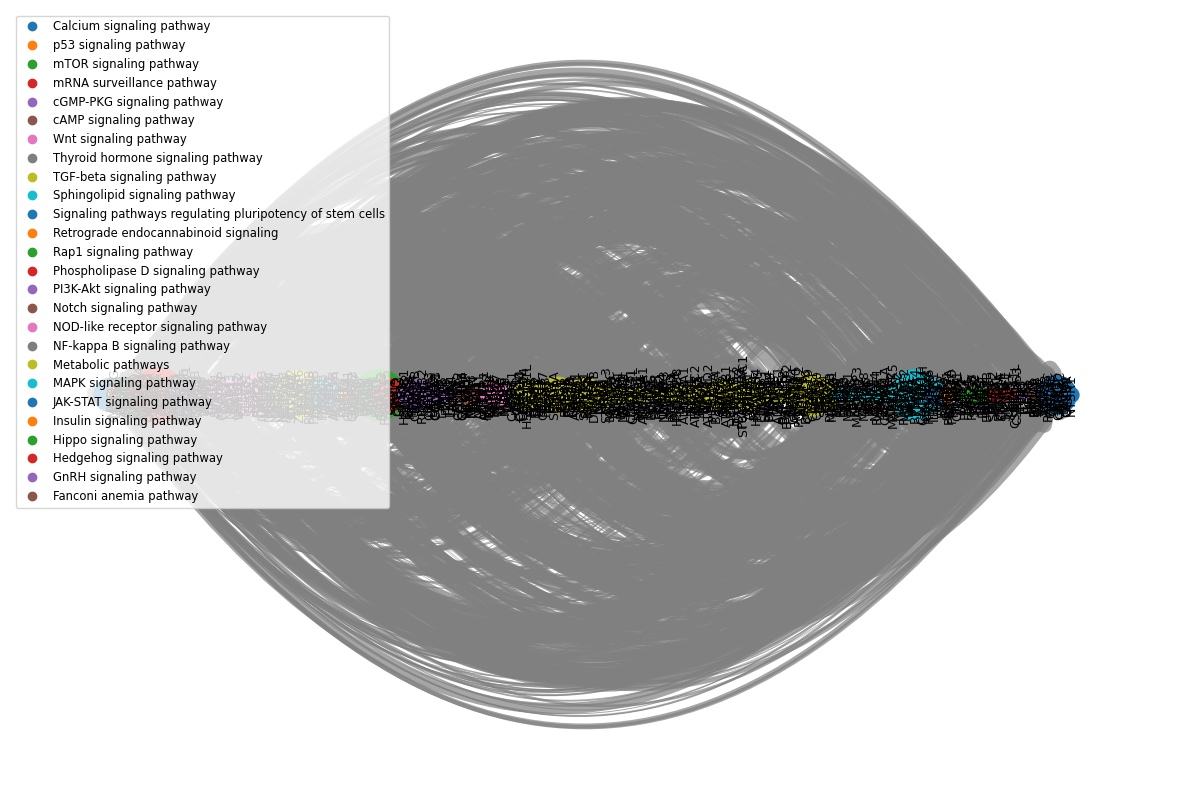

In [41]:
nod_cvcl_1304 = importance_nodes[importance_nodes['cell'] == 'CVCL_1304']
nod_cvcl_1304 = nod_cvcl_1304[['p1_name', 'node_importance']]
nod_cvcl_1304 = nod_cvcl_1304.rename(columns={'p1_name': 'node'})

data_ = data[data['p1_name'].isin(data['p2_name'])]
data_ = data_.sort_values(by='biological_processes', ascending=False) 
data_ = pd.concat([data_.iloc[-4:], data_.iloc[:-4]], axis=0)
data_ = data_.merge(nod_cvcl_1304, left_on='p2_name', right_on='node', how='left')

# Sample node data with class information
#nodes = data_['p2_name'].unique()
nodes = data_['p2_name'].unique()

# Sample class data
classes = data_['biological_processes'].unique()

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for node in nodes:
    G.add_node(node)

# Add edges to the graph
edges = data_[['p2_name', 'p1_name']].values.tolist()  # Specify the edges
for edge in edges:
    G.add_edge(edge[0], edge[1])

# Draw the graph
plt.figure(figsize=(15, 10))

# Sort nodes based on class
#nodes_sorted = sorted(nodes, key=lambda node: data_.loc[data_['p2_name'] == node, 'biological_processes'].values[0], reverse=True)
nodes_sorted = data_['p2_name'].unique().tolist()

# Specify the positions of the nodes on a line with increased spacing
node_spacing = 2  # Adjust the spacing between nodes
node_positions = {node: (i * node_spacing, 0) for i, node in enumerate(nodes_sorted)}

# Generate class colors automatically
num_classes = len(classes)
palette = sns.color_palette('tab10', num_classes)
class_colors = {cls: color for cls, color in zip(classes, palette)}

# Create a list of node colors based on classes
node_colors = [class_colors[data_.loc[data_['p2_name'] == node, 
                'biological_processes'].values[0]] for node in nodes_sorted]

# Create a list of node sizes based on node weights
node_sizes = [data_.loc[data_['p2_name'] == node, 'node_importance_x'].values[0] * 100000 for node in nodes_sorted]
# Draw nodes with colors based on classes
nx.draw_networkx_nodes(G, node_positions, node_color=node_colors, 
                       node_size=node_sizes)

# Draw node labels with rotation
node_labels = {node: node for node in nodes_sorted}
text = nx.draw_networkx_labels(G, node_positions, labels=node_labels, font_size=9)
for _, t in text.items():
    t.set_rotation('vertical') 

# Draw edges
nx.draw_networkx_edges(G, node_positions, width=data_.attention*5, edge_color='gray', alpha=0.7, connectionstyle='arc3,rad=0.7')

# Create legend
legend_labels = {cls: cls for cls in classes}
legend_handles = [plt.Line2D([], [], color=class_colors[cls], marker='o', linestyle='None', markersize=6) for cls in classes]
plt.legend(legend_handles, legend_labels.values(), loc='upper left', fontsize='small')

# Show the graph
plt.axis('off')
plt.show()

In [42]:
for cell in att_df['cell'].unique():
    df = att_df[att_df['cell'] == cell]
    df_im = importance_nodes[importance_nodes['cell'] == cell]
    df.sort_values(by=['attention'], ascending=False, inplace=True)

/tmp/ipykernel_254385/1579456705.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/ipykernel_254385/3862130622.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_254385/3862130622.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



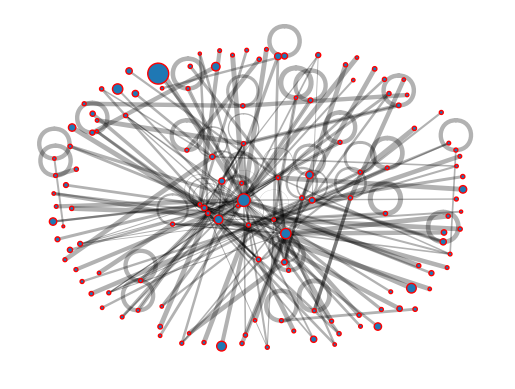

In [43]:
# Define the percent of edges to be selected
percent_edges_selected = 0.1
# Get the top 'percent_edges_selected' edges based on the edge attribute
num_edges_selected = int(percent_edges_selected * len(
    df['attention']))


# Create a new graph with only the selected edges
# G_selected = nx.DiGraph()
dfc=df[:num_edges_selected]

# Select edges from df based on coresponding nodes in dfc
dfc = df[df['protein_1'].isin(dfc['protein_1'])]
G_selected = nx.from_pandas_edgelist(dfc, 
        'p1_name', 'p2_name', edge_attr='attention', 
        create_using=nx.DiGraph()
        )

# Select edges in df_im from dfc and get the corresponding nodes
# dfc.p1_name.unique()
unique_names = list(dfc.p1_name.unique()) + list(dfc.p2_name.unique())
df_imc = df_im[df_im['p1_name'].isin(unique_names)]
# Draw the graph
df_imc['node_importance'] = df_imc['node_importance']*50000
# change the type of node_importance to int
df_imc['node_importance'] = df_imc['node_importance'].astype(int)

nx.set_node_attributes(G_selected, dict(zip(
    df_imc['p1_name'], df_imc['node_importance'])), 'node_importance')
#select layout of graph
pos = nx.spring_layout(G_selected, scale=0.5, k=0.55, iterations=50)
#pos = nx.circular_layout(G_selected, scale=0.5)

nx.get_node_attributes(G_selected, "node_importance")
# make a list of node_importance
node_importance = list(nx.get_node_attributes(G_selected, "node_importance").values())
widths = nx.get_edge_attributes(G_selected, 'attention')
nodelist = G_selected.nodes()
len(node_importance)
nx.draw_networkx_nodes(G_selected, pos, node_size=node_importance,
                       edgecolors='red')
nx.draw_networkx_edges(G_selected,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values())*40,
                       edge_color='black',
                       alpha=0.3, arrows=False)
# nx.draw_networkx_labels(G_selected, pos=pos,
#                         labels=dict(zip(nodelist,nodelist)),
#                         font_color='black')
plt.axis('off')
plt.show()

In [45]:
# Create a dictionary of graphs, one for each cell
graphs = {}
for cell in att_df['cell'].unique():
    df = att_df[att_df['cell'] == cell]
    df_im = importance_nodes[importance_nodes['cell'] == cell]
    G = nx.from_pandas_edgelist(df, 'p1_name', 'p2_name', edge_attr='attention')
    node_size_dict = dict(zip(df_im['p1_name'], df_im['node_importance']))
    edge_size_dict = dict(zip([e[0]+e[1] for e in G.edges()], [d['attention']*100 for u,v,d in G.edges(data=True)]))
    # edge_widths = [d['attention']*100 for u,v,d in G.edges(data=True)]
    graphs[cell] = {'G': G, 
                    'edge_size_dict': edge_size_dict,
                    'node_size_dict': node_size_dict}
    # create edge widths based on attention
    


In [53]:
from collections import deque
#import dcc
from dash import Dash, dcc, html, Input, Output
def queue(a, b, qty):
    """either x0 and x1 or y0 and y1, qty of points to create"""
    q = deque()
    q.append((0, qty - 1))  # indexing starts at 0
    pts = [0] * qty
    pts[0] = a
    pts[-1] = b  # x0 is the first value, x1 is the last
    while len(q) != 0:
        left, right = q.popleft()  # remove working segment from queue
        center = (left + right + 1) // 2  # creates index values for pts
        pts[center] = (pts[left] + pts[right]) / 2
        if right - left > 2:  # stop when qty met
            q.append((left, center))
            q.append((center, right))
    return pts

def make_middle_points(first_x, last_x, first_y, last_y, qty):
    """line segment end points, how many midpoints, hovertext"""
    # Add 2 because the origin will be in the list, pop first and last (the nodes)
    middle_x_ = queue(first_x, last_x, qty + 2)
    middle_y_ = queue(first_y, last_y, qty + 2)
    middle_x_.pop(0)
    middle_x_.pop()
    middle_y_.pop(0)
    middle_y_.pop()
    return middle_x_, middle_y_
# Create plotly figure
def update_figure(cell, num_nodes, node_factor = 200, edge_factor = 10, edge_points_quantity = 10):
    G = graphs[cell]['G']
    
    node_size_dict = graphs[cell]['node_size_dict']
    edge_size_dict = graphs[cell]['edge_size_dict']

    nodes_sorted = sorted(node_size_dict, key=node_size_dict.get, reverse=True)
    num_nodes = round(num_nodes / 100 * len(nodes_sorted))
    nodes_to_display = nodes_sorted[:num_nodes]
    node_size = [node_size_dict[node] * 500 for node in nodes_to_display]
    edge_widths = [d['attention']*edge_factor for u,v,d in G.edges(data=True)]
    
    pos = nx.spring_layout(G, seed=42)
     
    edge_trace = go.Scatter(
        x=[], y=[], 
        line=dict(color='#888'),
        hoverinfo='text', text=[] , mode='lines',
        )
    node_trace = go.Scatter(
        x=[], y=[], 
        mode='markers',
        hoverinfo='text', text=[], 
        marker=dict(
            showscale=True,
            colorscale='rdylbu',
            reversescale=True,
            color=[],  size=[],
            colorbar=dict(
                thickness=15, title='Node Importance',
                xanchor='left', titleside='right',
            ),
            line_width=2))
    for node in G.nodes():
        if node in nodes_to_display:
            x, y = pos[node]
            node_trace['x'] += tuple([x])
            node_trace['y'] += tuple([y])
            node_trace['text'] += tuple([
                f"{node}:<br> Importance:{node_size_dict[node]:.4f} <br> " + 
                f"Edges: {G.degree[node]}<br>"])
            node_trace['marker']['color'] += tuple([node_size_dict[node]])
            node_trace['marker']['size'] += tuple([node_size_dict[node]*node_factor])
    
    width, edge_node_size = [], []
    edge_middle_x, edge_middle_y, edge_middle_text = [], [], []
    for edge in G.edges():
        if edge[0] in nodes_to_display or edge[1] in nodes_to_display:
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            ax = (x0+x1)/2
            ay = (y0+y1)/2
            edge_trace['x'] += tuple([x0, x1, None])
            edge_trace['y'] += tuple([y0, y1, None])
            # edge_trace['text'] += tuple([f"From: {edge[0]}<br>To: {edge[1]}Weight: {G[edge[0]][edge[1]]['attention']:.4f}"])
            edge_middle_text.extend([f"{edge[0]} -> {edge[1]} <br> "+ 
                        f"Weight: {G[edge[0]][edge[1]]['attention']:.4f}"
                        ] * edge_points_quantity)
            
            edge_node_size.extend([round(G[edge[0]][edge[1]]['attention'], 4)
                                   ] * edge_points_quantity)
            
            width.append((G.edges[edge]['attention'], ax, ay, x1, y1))
            middle_x, middle_y = make_middle_points(x0, 
                                x1, y0, y1, edge_points_quantity)
            
            edge_middle_x.extend(middle_x)
            edge_middle_y.extend(middle_y)
            
    m2node_trace = go.Scatter(x=edge_middle_x, y=edge_middle_y, 
                              mode="markers", showlegend=False,
                          hovertemplate="Edge # %{hovertext} <extra></extra>",
                          hovertext=edge_middle_text,
                          marker=go.Marker(opacity=0.3))
    
    annotations_list =[dict(x=weight[1], y=weight[2],
                            xref='x', yref='y',
                            width=round(weight[0]+1,1),
                            showarrow=True, arrowsize=2, arrowhead = 1,
                            #arrowwidth=round(weight[0]+3,1),
                            ax=weight[1], ay=weight[2]
                        ) for weight in width ]
    
    subtitle = f"Top size, node: <br>"
    for k,i in enumerate(nodes_to_display):
        subtitle += f"{node_size_dict[i]:.5f}, {i} <br>"
        if k>4:
            break
    subtitle += f"... <br> Total num nodes: {len(G.nodes)} <br>"
        
    fig = go.Figure(data=[edge_trace, node_trace, m2node_trace],
                    layout=go.Layout(
                        title=f'<br>Protein Interaction Network ({cell}), Selected Nodes: {num_nodes}',
                        titlefont_size=12,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=annotations_list,
                        xaxis=dict(showgrid=False, zeroline=False,
                                   showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False,
                                   showticklabels=False)))
    fig.add_annotation(
    xref="x domain",
    yref="y",
    x=0.2,
    y=1,
    text= subtitle,
    )
    return fig

# Create dropdown menu and slider for user input
cell_options = [{'label': cell, 'value': cell} for cell in graphs.keys()]
num_nodes_slider = dcc.Slider

## Melanoma cancer cell line

In [54]:
update_figure('CVCL_1779', 20, node_factor = 500, 
              edge_factor = 20, edge_points_quantity = 1)

/opt/conda/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:434: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.


